In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, ElasticNetCV, LogisticRegression, LinearRegression


import sys
import os
import json

sys.path.append(os.path.abspath("../"))

from models.dml import D2ML

In [2]:
%matplotlib inline

# Comparing causal inference models with RCT benchmark
### DATA
- とても有名な職業訓練RCTデータ
- LaLonde(1986)[ "Evaluating the Econometric Evaluations of Training Programs with Experiment Data"](https://www.researchgate.net/publication/4900843_Evaluating_the_Econometric_Evaluations_of_Training_Programs_with_Experiment_Data)
- 条件を満たす失業者にカウンセリングと短期職業経験の実施（＝treat）するというRCT

|   name  |  意味  |
| :-------------: | :-------------: |
|  treat  |  介入|
|  age  |  年齢 |
|  education |  学歴  |
|  black  |  アフリカ系=1 or 0  |
|  hispanic  |  ヒスパニック系=1 or 0  |
| married  |  結婚有無 |
|  nodegree	  |  学位がない=1 |
| re74  |  74年の年収  |
|  re75  |  75年の年収  |
|  re78  |  78年の年収(アウトカム)  |

- 今回はこれにCPS調査で直前に無職だった人もいれて、人工的にバイアスを作り出す

In [3]:
RCT_DATA = "http://www.nber.org/~rdehejia/data/nsw_dw.dta"
CPS_DATA = "http://www.nber.org/~rdehejia/data/cps_controls3.dta"  # cps調査で直前に無職だったものに限定

In [4]:
rct_df = pd.read_stata(RCT_DATA )
del rct_df["data_id"]

rct_df["treat"] = rct_df["treat"].astype(int)
rct_df.head()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,1,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,1,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,1,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,1,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [5]:
def p_value_color(df):
    styles = df.copy()
    styles.iloc[:, :] = ""
    idx_ = df["p_value"] <= 0.05
    styles.loc[idx_, :] = "color:purple"
    return styles

In [6]:
base_values = [col for col in rct_df.columns if col != "treat"]
_pivot = pd.pivot_table(
    rct_df,
    columns="treat",
    values=base_values,
    # margins=True,
    aggfunc=["count", np.mean, np.median, np.std],
)
_pivot["t_statistic"] = 0
_pivot["p_value"] = 0

for _value in base_values:
    _stat, _p = stats.ttest_ind(
        *rct_df.dropna(subset=[_value])
        .groupby("treat")[_value]
        .apply(lambda x: list(x)),
        equal_var=False
    )
    _pivot.loc[_value, "t_statistic"] = _stat
    _pivot.loc[_value, "p_value"] = _p

_pivot.style.apply(p_value_color, axis=None)

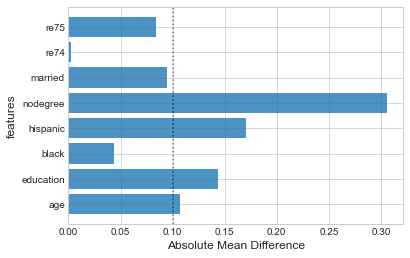

In [7]:
# 分析前の共変量バランス
def cal_abs_mean_diff(df):
    # (treatment群の平均 - control群の平均) / 全体の標準誤差
    return (
        (
            df.query("treat>0").drop("treat", axis=1).mean()
            - df.query("treat<1").drop("treat", axis=1).mean()
        )
        / df.drop("treat", axis=1).std()
    ).abs()


# 調整前のAbsolute Mean Difference
unadjusted_balance = rct_df[
    [
        "treat",
        "age",
        "education",
        "black",
        "hispanic",
        "nodegree",
        "married",
        "re74",
        "re75",
    ]
]
unadjusted_balance = cal_abs_mean_diff(unadjusted_balance)

fig, ax = plt.subplots()
# ax.set_title("共変量バランス（調整前）", fontsize=14)
ax.set_xlabel("Absolute Mean Difference", fontsize=12)
ax.set_ylabel("features", fontsize=12)
ax.barh(unadjusted_balance.index, unadjusted_balance, alpha=0.8)
ax.axvline(x=0.1, alpha=0.5, color="black", linestyle="dotted")
plt.show()

In [8]:
# multi regression
all_featuers = [col for col in rct_df.columns if "re78" not in col]

multi_formula = "re78 ~ "
for i, _featuer in enumerate(all_featuers):
    if i == 0:
        multi_formula += f"{_featuer}"
    else:
        multi_formula += f" + {_featuer}"
print(multi_formula)

rct_multi_regression = smf.ols(multi_formula, data=rct_df).fit()
rct_multi_regression.summary()

re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re75


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.804
Date:                Wed, 06 Apr 2022   Prob (F-statistic):            0.00329
Time:                        10:23:45   Log-Likelihood:                -4534.2
No. Observations:                 445   AIC:                             9088.
Df Residuals:                     435   BIC:                             9129.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    785.0614   3374.969      0.233      0.816   -5848.211    7418.334
treat       1676.3426    638.682      2.625      0.009     421.056    2931.629
age           55.3167     45.284      1.222      0.223     -33.686     144.319
education    395.7343    227.415      1.740      0.083     -51.234     842.703
black      -2159.5222   1169.036     -1.847      0.065   -4457.183     138.139
hispanic     164.0327   1549.457      0.106      0.916   -2881.320    3209.386
married     -138.7253    879.728     -0.158      0.875   -1867.771    1590.321
nodegree     -70.6806   1004.387     -0.070      0.944   -2044.736    1903.374
re74           0.0821      0.077      1.061      0.289      -0.070       0.234
re75           0.0528      0.135      0.389      0.697      -0.214       0.319
==============================================================================
Omnibus:                      284.809   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3770.859
Skew:                           2.545   Prob(JB):                         0.00
Kurtosis:                      16.321   Cond. No.                     7.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
rct_effect = rct_multi_regression.params["treat"]
print("rct_effect : ", rct_effect)

rct_effect :  1676.3426254026263


## 検証用データを生成

In [10]:
df = pd.concat(
    [
        pd.read_stata(RCT_DATA).query("treat>0"),  # (失業者介入実験データ)nsw data の介入群のみ抽出
        pd.read_stata(CPS_DATA),  # 別のセンサスデータ
    ]
).reset_index(drop=True)

del df["data_id"]  # 不要なので消す

df["treat"] = df["treat"].astype(int)
df.sample(10)

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
275,0,30.0,16.0,0.0,0.0,0.0,0.0,3093.681885,4468.645020,15538.290039
477,0,31.0,12.0,1.0,0.0,1.0,0.0,0.000000,42.967739,11023.839844
332,0,24.0,10.0,0.0,0.0,1.0,1.0,4719.874023,2565.531982,2173.736084
493,0,22.0,12.0,0.0,0.0,1.0,0.0,9022.423828,0.000000,3342.617920
450,0,17.0,9.0,1.0,0.0,0.0,1.0,0.000000,297.193512,54.675880
530,0,55.0,3.0,0.0,0.0,0.0,1.0,1208.868042,0.000000,0.000000
208,0,47.0,8.0,1.0,0.0,1.0,1.0,9275.168945,8543.418945,0.000000
59,1,22.0,11.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1048.432007
443,0,24.0,12.0,0.0,0.0,1.0,0.0,9051.813477,327.628998,8547.170898
594,0,42.0,16.0,0.0,0.0,0.0,0.0,0.000000,0.000000,23764.800781


In [11]:
base_values = [col for col in df.columns if col != "treat"]
_pivot = pd.pivot_table(
    df,
    columns="treat",
    values=base_values,
    # margins=True,
    aggfunc=["count", np.mean, np.median, np.std],
)
_pivot["t_statistic"] = 0
_pivot["p_value"] = 0

for _value in base_values:
    _stat, _p = stats.ttest_ind(
        *df.dropna(subset=[_value])
        .groupby("treat")[_value]
        .apply(lambda x: list(x)),
        equal_var=False
    )
    _pivot.loc[_value, "t_statistic"] = _stat
    _pivot.loc[_value, "p_value"] = _p

_pivot.style.apply(p_value_color, axis=None)

In [12]:
y_col = "re78"
d_col = "treat"
x_cols = [col for col in df.columns if col not in [d_col , y_col]]

In [13]:
multi_formula = "re78 ~ "
for i, _featuer in enumerate(all_featuers):
    if i == 0:
        multi_formula += f"{_featuer}"
    else:
        multi_formula += f" + {_featuer}"
print(multi_formula)

multi_regression = smf.ols(multi_formula, data=df).fit()
multi_regression.params["treat"]

re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re75


1548.2437523585047

## IPW estimation for ATT

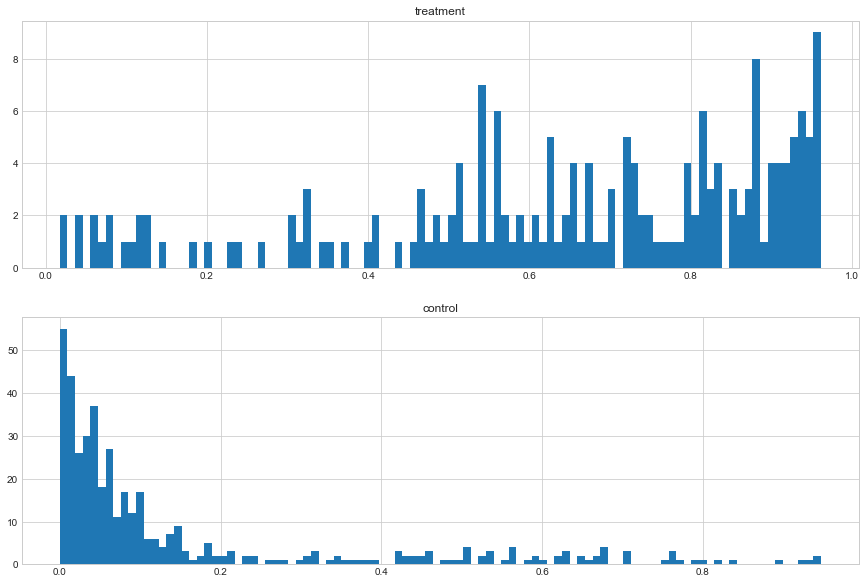

In [14]:
# ps modeling
ps_featuers = x_cols
ps_formula = "treat ~ "
for i, _featuer in enumerate(ps_featuers):
    if i == 0:
        ps_formula += f"{_featuer}"
    else:
        ps_formula += f" + {_featuer}"
ps_formula += "+ I(re74**2) + I(re75**2) + I(age**2) + I(education**2)"

ps_result = smf.glm(ps_formula, data=df, family= sm.families.Binomial()).fit()
df["ps"] = ps_result.predict()

plt.figure(figsize=(15, 10))
plt.subplot(211)
df.query("treat>0")["ps"].hist(bins=100)
plt.title("treatment")

plt.subplot(212)
df.query("treat<1")["ps"].hist(bins=100)
plt.title("control")
plt.show()

### IPW のATT版は以下のようなweightになる
- ps : 傾向スコア
- $D_i$ : 介入有無

$$
w_i^{ATT} = D_i + (1- D_i)\dfrac{ps}{1-ps}
$$
つまり
- 介入群にはそのまま weight = 1
- 統制群はweight = $ \frac{ps}{1-ps} $

In [15]:
# ATT
df["weight"] = df.apply(lambda x: 1 if x["treat"] >0 else x["ps"]/(1-x["ps"]), axis=1)

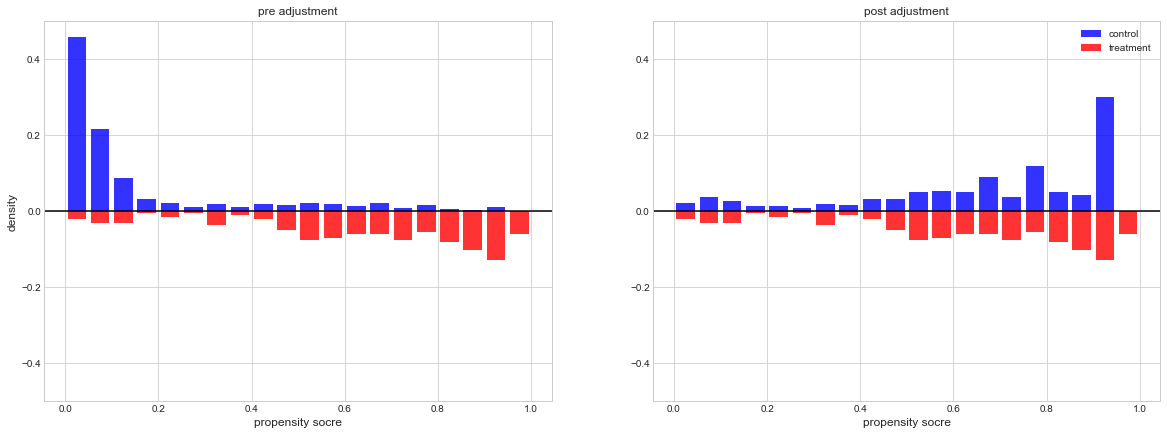

In [16]:
# 可視化
ps0 = df.ps[df.treat == 0]
ps1 = df.ps[df.treat == 1]

bins = np.arange(0, 1.05, 0.05)
hist0, _ = np.histogram(ps0, bins=bins)
hist1, _ = np.histogram(ps1, bins=bins)
hist0 = hist0 / sum(hist0)
hist1 = hist1 / sum(hist1)

w0g = df[["weight", "ps"]][df.treat == 0]
w1g = df[["weight", "ps"]][df.treat == 1]

w0g["bins"] = pd.cut(w0g["ps"], bins)
w1g["bins"] = pd.cut(w1g["ps"], bins)

w0g = w0g.groupby("bins").agg({"bins": "count", "weight": np.mean})
w0g = w0g.eval("bins * weight")

w1g = w1g.groupby("bins").agg({"bins": "count", "weight": np.mean})
w1g = w1g.eval("bins * weight")

w_hist0 = w0g.fillna(0).values
w_hist1 = w1g.fillna(0).values


w_hist0 = w_hist0 / sum(w_hist0)
w_hist1 = w_hist1 / sum(w_hist1)

fig, ax = plt.subplots(ncols=2, figsize=(20, 7))
# それぞれの値を調節
plt.subplots_adjust(wspace=0.2)

ax[0].bar(bins[:-1] + 0.025, hist0, width=0.04, facecolor="blue", alpha=0.8)
ax[0].bar(bins[:-1] + 0.025, -hist1, width=0.04, facecolor="red", alpha=0.8)
ax[0].axhline(0, c="black")
ax[0].set_ylabel("density", fontsize=12)
ax[0].set_ylim([-0.5, 0.5])
ax[0].set_title("pre adjustment", fontsize=12)
ax[0].set_xlabel("propensity socre", fontsize=12)

ax[1].bar(bins[:-1] + 0.025, w_hist0, width=0.04, facecolor="blue", alpha=0.8, label="control")
ax[1].bar(bins[:-1] + 0.025, -w_hist1, width=0.04, facecolor="red", alpha=0.8, label="treatment")
ax[1].axhline(0, c="black")
ax[1].set_ylim([-0.5, 0.5])
ax[1].set_title("post adjustment", fontsize=12)
ax[1].set_xlabel("propensity socre", fontsize=12)
plt.legend()
plt.show()

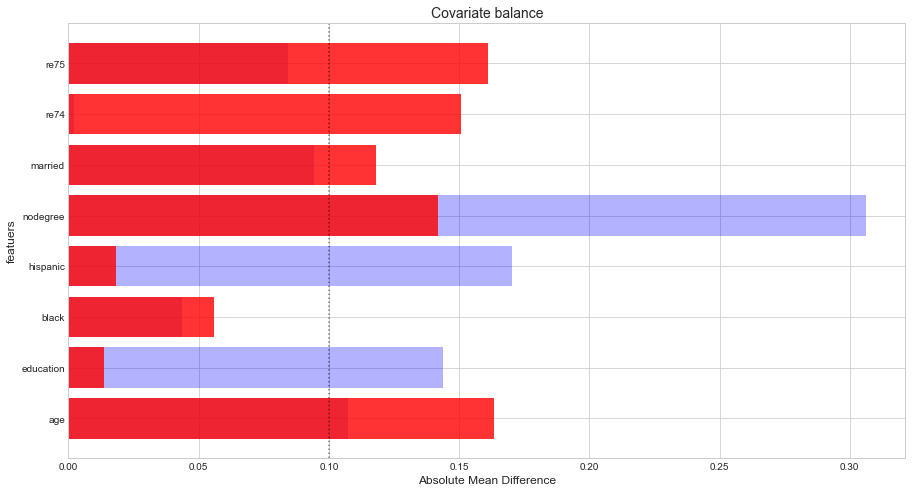

In [17]:
# IPWのAbusolute Mean Difference
def cal_weighted_mean_std(x, featuer="age", weight="weight", result_stats="mean"):
    # weighted_mean = np.average(x[featuer], weights=x[weight])
    # weighted_std = np.sqrt(np.average((x[featuer]-weighted_mean)**2, weights=x[weight]))
    # パッケージ発見
    from statsmodels.stats.weightstats import DescrStatsW

    weighted_stats = DescrStatsW(x[featuer], weights=x[weight], ddof=0)
    if result_stats == "mean":
        return weighted_stats.mean
    else:
        return weighted_stats.std


def cal_weighted_abs_mean_diff(df):
    featuers = [
        "age",
        "education",
        "black",
        "hispanic",
        "nodegree",
        "married",
        "re74",
        "re75",
    ]
    group_df = df.groupby("treat")
    result_dict = {}
    for col in featuers:
        weighted_mean = group_df.apply(cal_weighted_mean_std, featuer=col)
        weighted_std = cal_weighted_mean_std(
            df, featuer=col, weight="weight", result_stats="std"
        )

        result_dict[col] = abs(weighted_mean.diff()[1] / weighted_std)

    return pd.DataFrame(result_dict, index=["weighted_abs_mean_diff"]).T


adjusted_balance = cal_weighted_abs_mean_diff(df)
# 本当に特徴量がバランシングできているか確認する
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Covariate balance", fontsize=14)
ax.set_xlabel("Absolute Mean Difference", fontsize=12)
ax.set_ylabel("featuers", fontsize=12)
ax.barh(unadjusted_balance.index, unadjusted_balance, alpha=0.3, color="blue")
ax.barh(adjusted_balance.index, adjusted_balance["weighted_abs_mean_diff"], alpha=0.8, color="red")
ax.axvline(x=0.1,alpha=0.5, color="black",linestyle="dotted")
plt.show()

In [18]:
### 重み付きデータでの効果の推定
y = df.re78
X = df.treat
X = sm.add_constant(X)
ipw_result = sm.WLS(y, X, weights=df.weight).fit()
ipw_result.params["treat"]

1840.953903041877

# DML

In [19]:
dml = D2ML(
    data=df,
    t_col=d_col,
    y_col=y_col,
    x_cols_for_t=x_cols,
    x_cols_for_y=x_cols,
    x_cols_for_cate=x_cols,
    t_model= LGBMClassifier(random_state=0),
    outcome_model=LGBMRegressor(random_state=0),
    cate_model=LGBMRegressor(random_state=0),
)

In [20]:
dml.fit_ate()
dml.fit_nonlinear_cate()

In [51]:
dml.summary(effect_type="ate")

,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,562.217513,1013.608719,0.554669,0.579121,-1424.419071,2548.854098


In [21]:
dml.summary(effect_type="att")

100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,1663.972451,3226.850028,0.515665,0.606089,-4660.537387,7988.482289


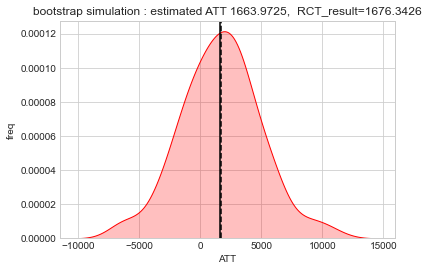

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sns.kdeplot(dml._bootstrap_att,shade=True, color='red', ax=ax)
ax.set_title(
    f"bootstrap simulation : estimated ATT {dml._att:.4f},  RCT_result={rct_effect:.4f}"
)
ax.set_xlabel("ATT")
ax.set_ylabel("freq")
ax.axvline(x=dml._att, color="black")
ax.axvline(x=rct_effect, color="black", linestyle="--")
fig.show()

In [23]:
pd.DataFrame(
    {
        "rct": [rct_effect, None],
        "multi-regression (OLS)": [
            multi_regression.params["treat"],
            abs(multi_regression.params["treat"] - rct_effect),
        ],
        "IPW for ATT": [
            ipw_result.params["treat"],
            abs(ipw_result.params["treat"] - rct_effect),
        ],
        "DML for ATT": [dml._att, abs(dml._att - rct_effect)],
    },
    index=["Estimated tau", "Absolute Error"],
).T

,Estimated tau,Absolute Error
rct,1676.342625,NaN
multi-regression (OLS),1548.243752,128.098873
IPW for ATT,1840.953903,164.611278
DML for ATT,1663.972451,12.370174


## meta-learner


In [24]:
from models.meta_learner import SLearner, TLearner, XLearner, DomainAdaptationLearner

In [25]:
linear_slearner = SLearner(
    data=df,
    t_col=d_col,
    y_col=y_col,
    x_cols=x_cols,
    outcome_model=LinearRegression(),
)

In [26]:
linear_slearner.summary( effect_type="att")

100%|██████████| 100/100 [00:01<00:00, 55.39it/s]


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,1548.372038,708.806206,2.184479,0.028927,159.137402,2937.606674


In [27]:
linear_slearner.summary( effect_type="ate")

,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,1548.372038,708.806206,2.184479,0.028927,159.137402,2937.606674


In [28]:
slearner = SLearner(
    data=df,
    t_col=d_col,
    y_col=y_col,
    x_cols=x_cols,
    outcome_model=LGBMRegressor(random_state=0),
)

In [29]:
slearner.summary( effect_type="att")

100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,821.905453,731.221711,1.124017,0.261006,-611.262766,2255.073672


In [30]:
slearner.summary( effect_type="ate")

,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,574.856849,532.413612,1.079719,0.280268,-468.654656,1618.368354


In [31]:
tlearner = TLearner(
    data=df,
    t_col=d_col,
    y_col=y_col,
    x_cols=x_cols,
    outcome_model=LGBMRegressor(random_state=0),
)

In [32]:
tlearner.summary( effect_type="att")

100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,794.218684,921.461522,0.861912,0.388736,-1011.812713,2600.250081


In [33]:
xlearner = XLearner(
    data=df,
    t_col=d_col,
    y_col=y_col,
    x_cols=x_cols,
    t_model= LGBMClassifier(random_state=0),
    outcome_model=LGBMRegressor(random_state=0),
)

In [34]:
xlearner.summary( effect_type="att")

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,1179.029339,979.115162,1.204178,0.228521,-740.001115,3098.059793


In [35]:
dalearner = DomainAdaptationLearner(
    data=df,
    t_col=d_col,
    y_col=y_col,
    x_cols=x_cols,
    t_model= LGBMClassifier(random_state=0),
    outcome_model=LGBMRegressor(random_state=0),
)

In [36]:
dalearner.summary( effect_type="att")

100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,642.48281,976.206759,0.658142,0.510447,-1270.84728,2555.812899


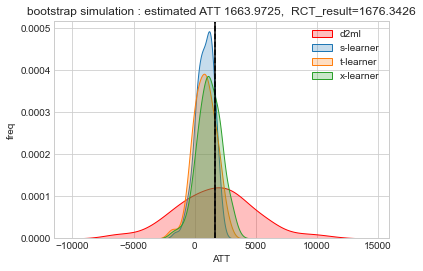

In [37]:
# D2ML のseはひどいけど、、、
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sns.kdeplot(dml._bootstrap_att,shade=True, color='red', ax=ax, label="d2ml")
sns.kdeplot(slearner._bootstrap_att,shade=True, ax=ax, label="s-learner")
sns.kdeplot(tlearner._bootstrap_att,shade=True, ax=ax, label="t-learner")
sns.kdeplot(xlearner._bootstrap_att,shade=True, ax=ax, label="x-learner")
ax.set_title(
    f"bootstrap simulation : estimated ATT {dml._att:.4f},  RCT_result={rct_effect:.4f}"
)
ax.set_xlabel("ATT")
ax.set_ylabel("freq")
ax.axvline(x=dml._att, color="black")
ax.axvline(x=rct_effect, color="black", linestyle="--")
ax.legend()
fig.show()

In [38]:
pd.DataFrame(
    {
        "rct": [rct_effect, None],
        "multi-regression (OLS)": [
            multi_regression.params["treat"],
            abs(multi_regression.params["treat"] - rct_effect),
        ],
        "IPW for ATT": [
            ipw_result.params["treat"],
            abs(ipw_result.params["treat"] - rct_effect),
        ],
        "DML for ATT": [dml._att, abs(dml._att - rct_effect)],
        "S Learner for ATT": [
            slearner._att,
            abs(slearner._att - rct_effect),
        ],
        "T Learner for ATT": [
            tlearner._att,
            abs(tlearner._att - rct_effect),
        ],
        "X Learner for ATT": [
            xlearner._att,
            abs(xlearner._att - rct_effect),
        ],
         "DA Learner for ATT": [
            dalearner._att,
            abs(dalearner._att - rct_effect),
        ],
    },
    index=["Estimated tau", "Absolute Error"],
).T

,Estimated tau,Absolute Error
rct,1676.342625,NaN
multi-regression (OLS),1548.243752,128.098873
IPW for ATT,1840.953903,164.611278
DML for ATT,1663.972451,12.370174
S Learner for ATT,821.905453,854.437172
T Learner for ATT,794.218684,882.123941
X Learner for ATT,1179.029339,497.313286
DA Learner for ATT,642.482810,1033.859815


# DMLDiD

In [39]:
from models.dmldid_ro import DMLDiD_RO

In [40]:
y0_col = "re75"
y1_col = "re78"

In [41]:
lgbm_dmldid = DMLDiD_RO(
    d_model=LGBMClassifier(random_state=0),
    l1k_model=LGBMRegressor(random_state=0),
)

In [42]:
lgbm_dmldid.fit(df, y1_col, y0_col, d_col, x_cols ,dmldid=False, sim_cnt=100)
print("lgbm Abadie att :", lgbm_dmldid.att())
lgbm_dmldid.summary()

lgbm Abadie att : 2972.10912417266


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,2972.109124,4.547474e-13,6.535737e+15,0.0,2972.109124,2972.109124


In [43]:
lgbm_dmldid.fit(df, y1_col, y0_col, d_col, x_cols ,dmldid=True, sim_cnt=100,  progress_plot=True)
print("lgbm dmldid att :", lgbm_dmldid.att())
lgbm_dmldid.summary()

99. att :  1719.6713139348694
lgbm dmldid att : 1743.2205770933124


,effect,standard_error,z_stat,p_value,CI 0.05,CI 0.95
t,1743.220577,2222.765106,0.784258,0.432889,-2613.318977,6099.760131


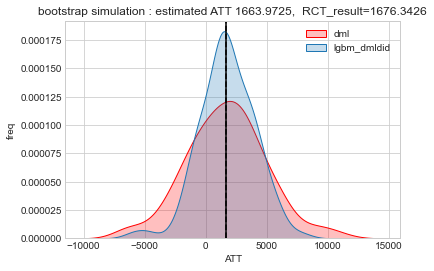

In [44]:
# D2ML のseはひどいけど、、、
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sns.kdeplot(dml._bootstrap_att,shade=True, color='red', ax=ax, label="dml")
sns.kdeplot(lgbm_dmldid.sim_att_result(),shade=True, ax=ax, label="lgbm_dmldid")

ax.set_title(
    f"bootstrap simulation : estimated ATT {dml._att:.4f},  RCT_result={rct_effect:.4f}"
)
ax.set_xlabel("ATT")
ax.set_ylabel("freq")
ax.axvline(x=dml._att, color="black")
ax.axvline(x=rct_effect, color="black", linestyle="--")
ax.legend()
fig.show()

In [45]:
%load_ext rpy2.ipython

In [46]:
%R -i df

In [47]:
%%R 
# install.packages("devtools")
#devtools::install_github("pedrohcgs/DRDID")
library(DRDID)

set.seed(123)
# Select some covariates
covX = as.matrix(cbind(df$age, df$educ,
                       df$black, df$married,
                       df$nodegree, df$hisp,
                       df$re74))

# Implement traditional DR locally efficient DID with panel data
drdid_result = drdid_panel(y1 = df$re78, y0 = df$re75,
             D = df$treat,
             covariates = covX)

dfdid_att = drdid_result$ATT
drdid_result

 Call:
drdid_panel(y1 = df$re78, y0 = df$re75, D = df$treat, covariates = covX)
------------------------------------------------------------------
 Locally efficient DR DID estimator for the ATT:
 
   ATT     Std. Error  t value    Pr(>|t|)  [95% Conf. Interval] 
1118.5753   816.0387    1.3707     0.1705   -480.8605   2718.011 
------------------------------------------------------------------
 Estimator based on panel data.
 Outcome regression est. method: OLS.
 Propensity score est. method: maximum likelihood.
 Analytical standard error.
------------------------------------------------------------------
 See Sant'Anna and Zhao (2020) for details.

In [48]:
%R -o dfdid_att

In [50]:
pd.DataFrame(
    {
        "rct": [rct_effect, None],
        "multi-regression (OLS)": [
            multi_regression.params["treat"],
            abs(multi_regression.params["treat"] - rct_effect),
        ],
        "IPW for ATT": [
            ipw_result.params["treat"],
            abs(ipw_result.params["treat"] - rct_effect),
        ],
        "DML for ATT": [dml._att, abs(dml._att - rct_effect)],
        "S Learner for ATT": [
            slearner._att,
            abs(slearner._att - rct_effect),
        ],
        "T Learner for ATT": [
            tlearner._att,
            abs(tlearner._att - rct_effect),
        ],
        "X Learner for ATT": [
            xlearner._att,
            abs(xlearner._att - rct_effect),
        ],
         "DA Learner for ATT": [
            dalearner._att,
            abs(dalearner._att - rct_effect),
        ],
        "DRDID (R pkg)": [
            dfdid_att[0],
            abs(dfdid_att[0] - rct_effect),
        ],
        "DMLDID": [
            lgbm_dmldid.att(),
            abs(lgbm_dmldid.att() - rct_effect),
        ],
    },
    index=["Estimated tau", "Absolute Error"],
).T

,Estimated tau,Absolute Error
rct,1676.342625,NaN
multi-regression (OLS),1548.243752,128.098873
IPW for ATT,1840.953903,164.611278
DML for ATT,1663.972451,12.370174
S Learner for ATT,821.905453,854.437172
T Learner for ATT,794.218684,882.123941
X Learner for ATT,1179.029339,497.313286
DA Learner for ATT,642.482810,1033.859815
DRDID (R pkg),1118.575265,557.767360
DMLDID,1743.220577,66.877952
